In [7]:
from ml.models.layers import MyTransformerBlock, MyAddPositionEmbs, MyClassToken
import os
import datetime
from pathlib import Path
from tensorflow.keras.models import load_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.callbacks import TensorBoard
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import Adam

from cfg import LOG_DIR

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipelineEncoderDecoder
import tensorflow
from tensorflow import keras

tensorflow.compat.v1.disable_eager_execution()


name = 'MySimpleCNN_Autoencoder_neighb'

class MyAutoencoder(FeitDataPipelineEncoderDecoder):

    def _train_model(self, data_train, data_valid):
        raise NotImplementedError("This method is intentionally not implemented in this instance")

    def __init__(self, *args, **kwargs):

        self.params.tile_size=256
        super().__init__(*args, **kwargs)

        self.params.latent_representation_size = 11
        self.params.tile_size=256
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.model = MyAutoencoder.get_model(self.params.latent_representation_size)
        self.params.neighborhood_tiles = 1


    def get_optimizer(self):
        lr_schedule = schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=100,
            decay_rate=0.1,
            staircase= True)

        return Adam(
            # learning_rate=0.1,
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999)

    @staticmethod
    def get_encoder(encoder_vector_length: int):
        pass

    @staticmethod
    def get_decoder(encoder_vector_length: int):
        pass


    @staticmethod
    def get_model(encoder_vector_length: int):
        return load_model('/home/jelinek/recetox/saved-models/' + "MySimpleCnn_Feit-reduced-rgb-no-inception" + '.h5')

    def get_combinator_model(self):

        inputs = [keras.Input(shape=(self.params.latent_representation_size, )) for i in range((self.params.neighborhood_tiles * 2 + 1) ** 2)]

        reshaped = [keras.layers.Reshape((1, self.params.latent_representation_size))(_input) for _input in inputs]
        x = keras.layers.Concatenate(axis=1)(reshaped)
        x = keras.layers.Flatten()(x)

        # x = MyClassToken(name="class_token")(x)
        # x = MyAddPositionEmbs(name="Transformer/posembed_input")(x)
        #
        # x, _ = MyTransformerBlock(num_heads=1, mlp_dim=self.params.latent_representation_size, dropout=0.1)(x)
        # x, _ = MyTransformerBlock(num_heads=1, mlp_dim=self.params.latent_representation_size, dropout=0.1)(x)
        #
        # x, _ = MyTransformerBlock(num_heads=1, mlp_dim=self.params.latent_representation_size, dropout=0.1)(x)
        # x, _ = MyTransformerBlock(num_heads=1, mlp_dim=self.params.latent_representation_size, dropout=0.1)(x)
        #
        # x = keras.layers.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(x)
        # x = keras.layers.Lambda(lambda v: v[:, 0], name="ExtractToken")(x)
        # x = keras.layers.Dense(512, name="pre_logits", activation="tanh")(x)

        # x = keras.layers.Dense(units=12, activation='sigmoid')(x)

        output = keras.layers.Dense(units = 11, activation = 'softmax')(x)

        neighborhood_model = keras.Model(inputs=inputs, outputs=output)
        return neighborhood_model

    def _train_model_ae_neighborhood(self, data_train_autoencoder, data_valid_autoencoder,
                                            data_train_classifier, data_valid_classifier,
                                           data_train_neighborhood, data_valid_neighborhood):

        autoencoder = MyAutoencoder.get_model(encoder_vector_length=self.params.latent_representation_size)

        inputs = autoencoder.input
        outputs = autoencoder.layers[-1].output

        encoder_model = keras.Model(inputs, outputs, name=(self.params.name + '_encoder'))

        self.model_encoder = encoder_model

        neighborhood_networks = [MyAutoencoder._get_basic_layers(keras.models.clone_model(encoder_model), model_idx)
                                 for model_idx in range((self.params.neighborhood_tiles * 2 + 1) ** 2)]


        encoders_outputs = [model[1] for model in neighborhood_networks]

        ## Here starts the Vision Transformer part of the model

        encoders_inputs = [model[0] for model in neighborhood_networks]

        tensorboard = TensorBoard(log_dir=LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

        neighbourhood_model = self.get_combinator_model()

        output = neighbourhood_model(encoders_outputs)

        neighborhood_autoencoder_model = keras.Model(inputs=encoders_inputs, outputs=output)

        neighborhood_autoencoder_model.compile(loss='binary_crossentropy', optimizer='adam',
                                               metrics=[keras.metrics.CategoricalAccuracy()])

        neighborhood_autoencoder_model.fit(data_train_neighborhood,
                       steps_per_epoch=250,
                       epochs=10,
                       shuffle=True,
                       validation_data=data_valid_neighborhood, validation_steps=100,
                       validation_freq=5,
                       verbose=1,
                       callbacks=[tensorboard, PlotLossesKerasTF()])

        self.model = neighborhood_autoencoder_model

        self.model_combinator = keras.Model(inputs = self.model.layers[-1].input, outputs = self.model.layers[-1].output)

        self.model_combinator.summary()

        self.model_combinator.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.CategoricalAccuracy()])

/home/jelinek/recetox


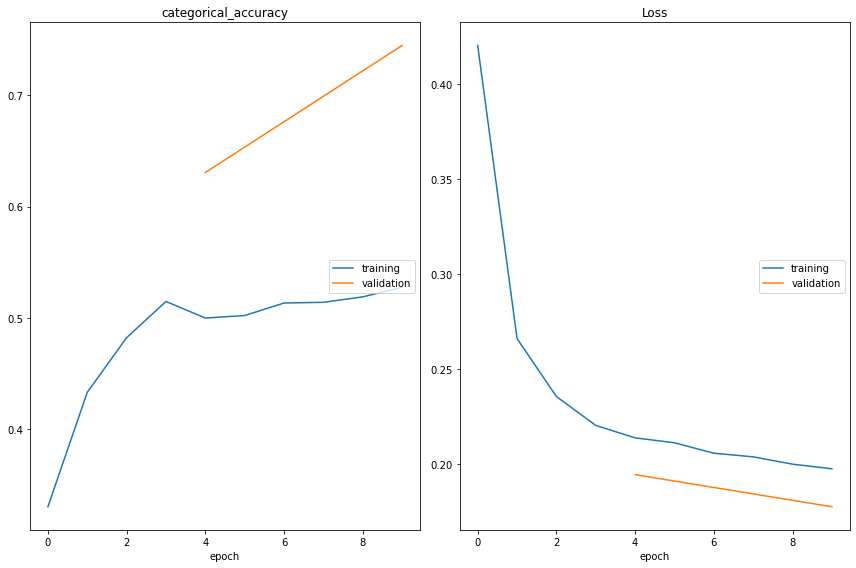

categorical_accuracy
	training         	 (min:    0.331, max:    0.528, cur:    0.528)
	validation       	 (min:    0.631, max:    0.745, cur:    0.745)
Loss
	training         	 (min:    0.197, max:    0.420, cur:    0.197)
	validation       	 (min:    0.177, max:    0.194, cur:    0.177)
250/250 [==============================] - 273s 1s/step - batch: 124.5000 - size: 32.0000 - loss: 0.1974 - categorical_accuracy: 0.5276 - val_loss: 0.1775 - val_categorical_accuracy: 0.7447
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 11)]         0                                            
________

In [8]:
pipeline = MyAutoencoder(
                         data_train_autoencoder='data/Feit_colon-annotation-tiles-128/data_train/',
                         data_valid_autoencoder='data/Feit_colon-annotation-tiles-128/data_valid/',
                         data_train_neighborhood='/media/jelinek/960 GB Disk/Feit_colon-annotation-tiles-256-1-neighborhood/data_train',
                         data_valid_neighborhood='/media/jelinek/960 GB Disk/Feit_colon-annotation-tiles-256-1-neighborhood/data_train',
                         train_data_dir='data/Feit_colon-annotation-tiles-128/data_train/',
                         valid_data_dir='data/Feit_colon-annotation-tiles-128/data_valid/')

pipeline.execute_pipeline(perform_validation=False, perform_test_segmentation=False)

In [9]:
pipeline.save_pipeline()

In [10]:
# pipeline = FeitDataPipelineEncoderDecoder.load_pipeline(pipeline_name=name)

In [11]:
from ml.eval import eval_model

eval_model(pipeline.model,
           pipeline.get_data_loader_validation_neighborhood(),
           pipeline_name=name,
           print_confusion_matrix=True,
           save_misclassified=True)

Measuring time
--Iteration 10/10
Batch size: 32
Mean time per tile 2.3761ms
Confusion Matrix
[[ 4893     0     0     0  1767     0     0     0     0     0    19]
 [  761    58     0     0   438     0     0     0     0     0     5]
 [ 1157     0     0     0  1652     0     0     0     0     0     1]
 [    0     0     0     0   206     0     0     0     0     0     0]
 [  285     0     0     0 10555     0     0     0     0     0     1]
 [   11     0     0     0     0     0     0     0     0     0     0]
 [  519     0     0     0  1010     0     0     0     0     0     1]
 [  474     0     0     0  1222     0     0     0     0     0     0]
 [    7     0     0     0     2     0     0     0     0     0     0]
 [    0     0     0     0     5     0     0     0     0     0     0]
 [ 3204     0     0     0  1415     0     0     0     0     0    28]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.43      0.73      0

In [12]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/ns-adenoca-colon-15071-2019-20x-he-4/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         128, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=pipeline.params.neighborhood_tiles, combinator_model=pipeline.model_combinator,
                                         combination_procedure='neural_networks')

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processing region 120 out of 120
Post-processing image...
Processing grid point 41664 out of 41664
Processing image took 75.59026288986206 seconds
Saving file...
File saved to segmentations/MySimpleCNN_Autoencoder_neighb/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
[[ 813   29    0    2 1001    0   13    6    7    9  617]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 484   22    0    1  104    0    2    3   10    1  129]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 422    3    0    0 1366    0    0    0    1    0 4052]
 [  55    5    0    0   40    0    0    0    0    0   16]
 [ 164    5    0    0   60    0    0    3    2    1   43]
 [ 765   33    0    2  100    0    5    5   18    4  221]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]]
                             precision    rec